In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil
import datetime

In [2]:
# Ensure reproducibility
torch.manual_seed(41)

# Force the use of CPU
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Transform to Tensor
transform = transforms.ToTensor()

# Load MNIST dataset
train_data = datasets.MNIST(root='C:/Users/ammar/Desktop/thesis', train=True,
                         	download=True, transform=transform)
test_data = datasets.MNIST(root='C:/Users/ammar/Desktop/thesis',
                        	train=False, download=True, transform=transform)

In [4]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

First training sample:
Label: 5


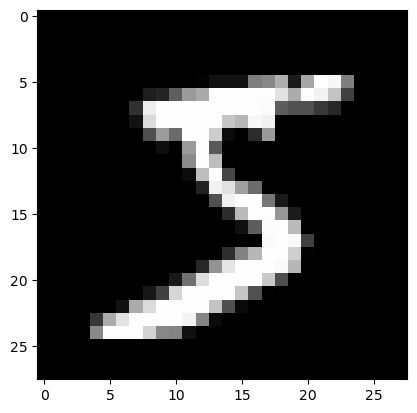

First test sample:
Label: 7


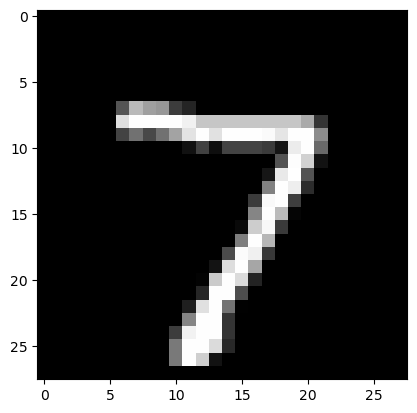

In [5]:
# Display first training and test sample
print("First training sample:")
image, label = train_data[0]
print(f"Label: {label}")
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

print("First test sample:")
image, label = test_data[0]
print(f"Label: {label}")
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

In [6]:
# Print image details
print("Image Shape:", image.shape)
print("Image Data Type:", type(image))
print("Label Data Type:", type(label))
image_numpy = image.numpy()
print("Pixel Value Range:", image_numpy.min(), "to", image_numpy.max())

Image Shape: torch.Size([1, 28, 28])
Image Data Type: <class 'torch.Tensor'>
Label Data Type: <class 'int'>
Pixel Value Range: 0.0 to 1.0


In [7]:
# Define CNN model
class ConvolutionalNetwork(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 6, 3, 1)
		self.conv2 = nn.Conv2d(6, 16, 3, 1)
		self.fc1 = nn.Linear(5*5*16, 120)
		self.fc2 = nn.Linear(120, 84)
		self.fc3 = nn.Linear(84, 10)
    
	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = F.max_pool2d(x, 2, 2)
		x = F.relu(self.conv2(x))
		x = F.max_pool2d(x, 2, 2)
		x = x.view(-1, 16*5*5)
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return F.log_softmax(x, dim=1)

In [8]:
# Initialize model, loss function, and optimizer
model = ConvolutionalNetwork().to(device) # To force it to run on cpu
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training parameters
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

In [10]:
start_time = time.time()

print("Training started at:", datetime.datetime.now().strftime("%H:%M:%S"))

# Training loop
for i in range(epochs):
	trn_corr = 0
	tst_corr = 0
    
	# Training phase
	model.train()
	for batch, (x_train, y_train) in enumerate(train_loader, 1):
		x_train, y_train = x_train.to(device), y_train.to(device)
		y_pred = model(x_train)
		loss = criterion(y_pred, y_train)
		
		predicted = torch.max(y_pred.data, 1)[1]
		trn_corr += (predicted == y_train).sum().item()
		
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		if batch % 600 == 0:
			print(f'Epoch: {i+1}, Batch: {batch}, Loss: {loss.item()}')
    
	train_losses.append(loss.item())
	train_correct.append(trn_corr)
    
	# Validation phase
	model.eval()
	test_loss = 0
	with torch.no_grad():
		for x_test, y_test in test_loader:
			x_test, y_test = x_test.to(device), y_test.to(device)
			y_val = model(x_test)
			loss = criterion(y_val, y_test)
			test_loss += loss.item()
			
			predicted = torch.max(y_val.data, 1)[1]
			tst_corr += (predicted == y_test).sum().item()
    
	test_losses.append(test_loss / len(test_loader))  # Average loss
	test_correct.append(tst_corr)

end_time = time.time()
print("Training ended at:", datetime.datetime.now().strftime("%H:%M:%S")) # To know watt and utilization using Intel Power Gadget
print(f'Training Took: {(end_time - start_time) / 60:.2f} minutes')

Training started at: 13:51:15
Training ended at: 13:51:59
Training Took: 0.73 minutes


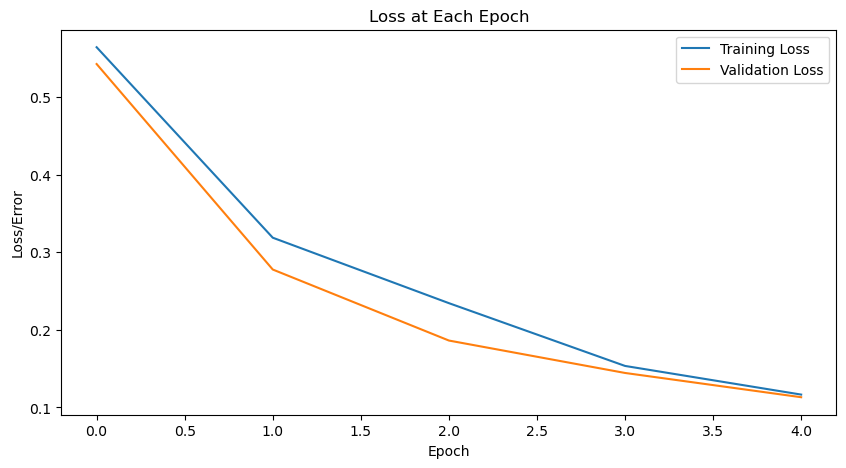

In [11]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss/Error")
plt.title("Loss at Each Epoch")
plt.legend()
plt.show()

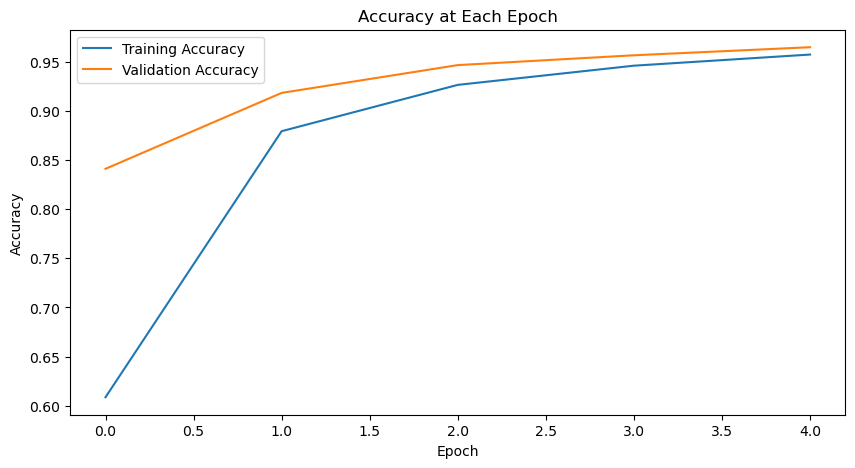

In [12]:
# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot([t / len(train_data) for t in train_correct], label="Training Accuracy")
plt.plot([t / len(test_data) for t in test_correct], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy at Each Epoch")
plt.legend()
plt.show()

In [13]:
# Final Model Evaluation
model.eval()
correct = 0
with torch.no_grad():
	for x_test, y_test in test_loader:
		x_test, y_test = x_test.to(device), y_test.to(device)
		y_val = model(x_test)
		predicted = torch.max(y_val, 1)[1]
		correct += (predicted == y_test).sum().item()

total_test_samples = len(test_data)
accuracy = correct / total_test_samples
print(f'Final Test Accuracy: {accuracy:.4f}')

Final Test Accuracy: 0.9649


In [35]:
print("Is CUDA available?", torch.cuda.is_available())


Is CUDA available? False
